<H1>HC in Cross-Domain Authorship Attribution Challenge</H1>
Use this notebook to replicate the results reporter in the paper  </br>
<ul>
    [1] <a href = https://arxiv.org/abs/1911.01208>
    Kipnis, A., ``Higher Criticism for Discriminating Word-Frequency Tables and Testing Authorship'', 2019
    </a>
</ul>

- Use HC-based test to attribute authorship in the PAN2018 cross-domain authorship attribution challenge https://pan.webis.de/clef18/pan18-web/author-identification.html#cross-domain
- Only the English part (problems 1-4) of this challenge is considered. 
- We use a lemmatized version of the data obtained using the Stanford CoreNLP (https://stanfordnlp.github.io/CoreNLP/)



In [1]:
import pandas as pd
import numpy as np
import os
import re
import codecs
from tqdm import tqdm

#import auxiliary functions for python
import sys
sys.path.append('../')
from AuthAttLib import *

<H2>Load Data</H2>
The data below was obtained by lemmatizing the original challenge test data using the Stanford CoreNLP lemmatizer https://stanfordnlp.github.io/CoreNLP/. 

In [2]:
#load data PAN2018 (from lemmatized) 
raw_data = pd.read_csv("../Data/PAN2018_lemmatized.csv")
raw_data.loc[:,'lem_text'] = raw_data.loc[:,'lem_text'] # + ' ' + raw_data.loc[:,'POS']
data = raw_data.filter(['dataset', 'author', 'doc_id'])

data.loc[:,'split'] = 'train'
data.loc[data.doc_id.str.find('test')>-1,'split'] = 'test'

Ignore proper names, numbers, and some pronouns: 

In [3]:
#remove proper names
data.loc[:,'text'] = raw_data.apply(
    lambda r : " ".join([w[0] for w in zip(r['lem_text'].split(),r['POS'].split()) if w[1] != 'PROPN']), axis=1)


<H2>Multi-author model</H2>

- For each problem in the challenge, train a model and evaluate it over a test set. <br>
- The following implementation opt not to use the UNNKOWN option, hence the recall is always 100%

In [32]:
lo_problem = pd.unique(data['dataset'])

lo_F1 = []
lo_acc = []

for prob in tqdm(lo_problem[:4]) :
    data_prob = data[data['dataset'] == prob]
    
    data_train = data_prob[data_prob['split'] == 'train']
    #compute model for each problem:
    model = AuthorshipAttributionMulti(
        data_train,        #dataset arrange in a data frame
        vocab_size=1500,  #uses 3000 most frequent ngram
        stbl=True,       #type of HC statistic
        ngram_range=(1,3), #mono-, bi-, and tri- grams
        randomize=True     #use randomized p-values
        )
    
    #attribute test documents:
    print("Evaluate on test set:")
    data_test = data_prob[data_prob['split'] == 'test']
    lo_test_docs = pd.unique(data_test.doc_id)
    df = pd.DataFrame() #save results in this dataframe

    for doc in tqdm(lo_test_docs) :
        sm = data_test[data_test.doc_id == doc]

        
        pred,_ = model.predict(sm.text.values[0], unk_thresh = 1e6, method = 'HC') 
                # can use 'unk_thresh' to get '<UNK>' instead of the name 
                # of the corpus with smallest HC in the case when the smallest
                # HC is above 'unk_thresh'. 

        auth = sm.author.values[0]
        df = df.append({'doc_id' : doc,
                   'author' : auth,
                   'predicted' : pred,
                  }, ignore_index = True)


    # evaluate accuracy and F1 score
    df_r = df[df.predicted != '<UNK>']
    recall = len(df_r) / len(df)
    acc = np.mean((df_r.predicted == df_r.author).values)
    
    print("problem = {}".format(prob))
    print("recall = {}".format(recall))
    print("accuracy = {}".format(acc))
    print("F1 = {}".format(2*recall*acc / (recall + acc)))
    lo_F1 += [2*recall*acc / (recall + acc)]
    lo_acc += [acc]

#prob1: |W| = 1500, ng = (1,3) --> F1 = 0.661, acc = 0.493
#prob2: |W| = 1500, ng = (1,3) --> F1 = 0.678, acc = 0.513
#prob3: |W| = 1500, ng = (1,3) --> F1 = 0.7878, acc = 0.65
#prob4: |W| = 1500, ng = (1,3) --> F1 = 0.814, acc = 0.6875


  0%|          | 0/4 [00:00<?, ?it/s]

	 Creating author-model for candidate00001 using 1500 features...
		found 7 documents and 8588 relevant tokens.
	 Creating author-model for candidate00002 using 1500 features...
		found 7 documents and 8498 relevant tokens.
	 Creating author-model for candidate00003 using 1500 features...
		found 7 documents and 7619 relevant tokens.
	 Creating author-model for candidate00004 using 1500 features...
		found 7 documents and 8383 relevant tokens.
	 Creating author-model for candidate00005 using 1500 features...
		found 7 documents and 7809 relevant tokens.
	 Creating author-model for candidate00006 using 1500 features...
		found 7 documents and 8443 relevant tokens.
	 Creating author-model for candidate00007 using 1500 features...
		found 7 documents and 7806 relevant tokens.
	 Creating author-model for candidate00008 using 1500 features...
		found 7 documents and 7433 relevant tokens.
	 Creating author-model for candidate00009 using 1500 features...
		found 7 documents and 7846 relevant 


  0%|          | 0/79 [00:00<?, ?it/s]

		found 7 documents and 8217 relevant tokens.
	 Creating author-model for candidate00015 using 1500 features...
		found 7 documents and 8421 relevant tokens.
	 Creating author-model for candidate00016 using 1500 features...
		found 7 documents and 7071 relevant tokens.
	 Creating author-model for candidate00017 using 1500 features...
		found 7 documents and 6825 relevant tokens.
	 Creating author-model for candidate00018 using 1500 features...
		found 7 documents and 8445 relevant tokens.
	 Creating author-model for candidate00019 using 1500 features...
		found 7 documents and 8658 relevant tokens.
	 Creating author-model for candidate00020 using 1500 features...
		found 7 documents and 8249 relevant tokens.
Evaluate on test set:



 25%|██▌       | 1/4 [00:04<00:12,  4.05s/it]s]

problem = PAN-problem00001
recall = 1.0
accuracy = 0.5822784810126582
F1 = 0.736
	 Creating author-model for candidate00001 using 1500 features...
		found 7 documents and 8852 relevant tokens.
	 Creating author-model for candidate00002 using 1500 features...
		found 7 documents and 6824 relevant tokens.
	 Creating author-model for candidate00003 using 1500 features...
		found 7 documents and 7603 relevant tokens.
	 Creating author-model for candidate00004 using 1500 features...
		found 7 documents and 8565 relevant tokens.
	 Creating author-model for candidate00005 using 1500 features...
		found 7 documents and 7114 relevant tokens.
	 Creating author-model for candidate00006 using 1500 features...
		found 7 documents and 8233 relevant tokens.
	 Creating author-model for candidate00007 using 1500 features...
		found 7 documents and 8456 relevant tokens.
	 Creating author-model for candidate00008 using 1500 features...
		found 7 documents and 8445 relevant tokens.
	 Creating author-model


  0%|          | 0/74 [00:00<?, ?it/s]

		found 7 documents and 7251 relevant tokens.
	 Creating author-model for candidate00010 using 1500 features...
		found 7 documents and 7751 relevant tokens.
	 Creating author-model for candidate00011 using 1500 features...
		found 7 documents and 7865 relevant tokens.
	 Creating author-model for candidate00012 using 1500 features...
		found 7 documents and 8108 relevant tokens.
	 Creating author-model for candidate00013 using 1500 features...
		found 7 documents and 8276 relevant tokens.
	 Creating author-model for candidate00014 using 1500 features...
		found 7 documents and 7823 relevant tokens.
	 Creating author-model for candidate00015 using 1500 features...
		found 7 documents and 8665 relevant tokens.
Evaluate on test set:



 50%|█████     | 2/4 [00:06<00:07,  3.70s/it]s]

problem = PAN-problem00002
recall = 1.0
accuracy = 0.6486486486486487
F1 = 0.7868852459016393
	 Creating author-model for candidate00001 using 1500 features...
		found 7 documents and 7296 relevant tokens.
	 Creating author-model for candidate00002 using 1500 features...
		found 7 documents and 8874 relevant tokens.
	 Creating author-model for candidate00003 using 1500 features...
		found 7 documents and 6842 relevant tokens.
	 Creating author-model for candidate00004 using 1500 features...
		found 7 documents and 8715 relevant tokens.
	 Creating author-model for candidate00005 using 1500 features...
		found 7 documents and 8562 relevant tokens.
	 Creating author-model for candidate00006 using 1500 features...
		found 7 documents and 8347 relevant tokens.
	 Creating author-model for candidate00007 using 1500 features...
		found 7 documents and 7874 relevant tokens.
	 Creating author-model for candidate00008 using 1500 features...



 15%|█▌        | 6/40 [00:00<00:00, 57.10it/s]

		found 7 documents and 8688 relevant tokens.
	 Creating author-model for candidate00009 using 1500 features...
		found 7 documents and 7757 relevant tokens.
	 Creating author-model for candidate00010 using 1500 features...
		found 7 documents and 8751 relevant tokens.
Evaluate on test set:



 75%|███████▌  | 3/4 [00:08<00:03,  3.06s/it]s]

problem = PAN-problem00003
recall = 1.0
accuracy = 0.8
F1 = 0.888888888888889



  0%|          | 0/16 [00:00<?, ?it/s]

	 Creating author-model for candidate00001 using 1500 features...
		found 7 documents and 7858 relevant tokens.
	 Creating author-model for candidate00002 using 1500 features...
		found 7 documents and 7814 relevant tokens.
	 Creating author-model for candidate00003 using 1500 features...
		found 7 documents and 8925 relevant tokens.
	 Creating author-model for candidate00004 using 1500 features...
		found 7 documents and 7056 relevant tokens.
	 Creating author-model for candidate00005 using 1500 features...
		found 7 documents and 7376 relevant tokens.
Evaluate on test set:



100%|██████████| 4/4 [00:09<00:00,  2.35s/it]s]

problem = PAN-problem00004
recall = 1.0
accuracy = 0.6875
F1 = 0.8148148148148148


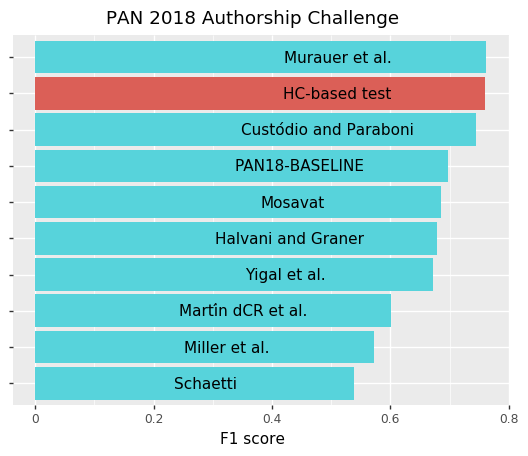

<ggplot: (298947317)>


/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/usr/local/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: /Users/kipnisal/Dropbox/Apps//Overleaf/Higher Criticism and Authorship Attribution (presentation)/Figs/PAN2018_F1.png
  warn('Filename: {}'.format(filename))


In [30]:
PAN2018_English_results = {
'Custódio and Paraboni' : 0.744,
'Murauer et al.' : 0.762,
'Halvani and Graner' :  0.679,
'Mosavat' : 0.685,
'Yigal et al.' : 0.672,
'Martín dCR et al.' : 0.601,
'PAN18-BASELINE' : 0.697,
'Miller et al.' : 0.573,
'Schaetti' :  0.538}

from plotnine import *

PAN2018_English_results['HC-based test'] = np.mean(lo_F1)

df = pd.DataFrame.from_dict(PAN2018_English_results, orient='index')
df = df.rename(columns = {0 : 'F1'}).reset_index()
dfs = df.sort_values('F1').reset_index()
df['cat'] = pd.Categorical(df.F1, categories=dfs['F1'].values, ordered=True)


df['type'] = 'other'
df.loc[df['index'] == 'HC-based test','type']='HC'

p = (ggplot(aes(x = 'cat', y = 'F1', fill = 'type', label = 'index'), data = df)
     + geom_bar(position='dodge', stat="identity", show_legend=False)
     + geom_text(nudge_y = -0.25) + coord_flip() + ggtitle('PAN 2018 Authorship Challenge')
     + xlab('') + theme(axis_text_y=element_blank())
     + ylab('F1 score')
    )
print(p)

path_to_plots = "/Users/kipnisal/Dropbox/Apps//Overleaf/Higher Criticism and Authorship Attribution (presentation)/Figs/"
p.save(path_to_plots + 'PAN2018_F1.png')

<h2>Multi-author with head-to-head comparisons</h2>

Compare each pair of corpora. Use only distinguishing features of two corpora in testing. Attribute tested docuement to whichever corpus has most number of wins in all pairwise comparisons.

In [11]:
lo_problem = pd.unique(data['dataset'])

lo_F1 = []
lo_acc = []

for prob in tqdm(lo_problem[2:4]) :
    data_prob = data[data['dataset'] == prob]
    data_train = data_prob[data_prob['split'] == 'train']
    
    #compute model for each problem:
    model = AuthorshipAttributionMultiBinary(data_train, 
                                       vocab_size = 1500,  #uses most frequent ngram
                                       stbl = True,  #type of HC statistic
                                      ngram_range = (1,3), #mono-, bi-, and tri- grams
                                         reduce_features=True,
                                         randomize=True
                                                )
    
    #attribute test documents:
    data_test = data_prob[data_prob['split'] == 'test']
    lo_test_docs = pd.unique(data_test.doc_id)
    df = pd.DataFrame() #save results in this dataframe

    for doc in tqdm(lo_test_docs) :
        sm = data_test[data_test.doc_id == doc]

        pred = model.predict(sm.text.values[0], method = 'chisq_pval', LOO = False) 
                # can use 'unk_thresh' to get '<UNK>' instead of the name 
                # of the corpus with smallest HC in the case when the smallest
                # HC is above 'unk_thresh'. 

        auth = sm.author.values[0]
        df = df.append({'doc_id' : doc,
                   'author' : auth,
                   'predicted' : pred,
                  }, ignore_index = True)


    # evaluate accuracy and F1 score
    df_r = df[df.predicted != '<UNK>']
    recall = len(df_r) / len(df)
    acc = np.mean((df_r.predicted == df_r.author).values)
    
    print("problem = {}".format(prob))
    print("recall = {}".format(recall))
    print("accuracy = {}".format(acc))
    print("F1 = {}".format(2*recall*acc / (recall + acc)))
    lo_F1 += [2*recall*acc / (recall + acc)]
    lo_acc += [acc]

#prob4: F1 = 0.72, acc = 0.5625, |W| = 100, ng = (1,3)


  0%|          | 0/2 [00:00<?, ?it/s]

Found 45 author-pairs
MultiBinaryAuthorModel: Creating model for candidate00001 vs candidate00002...
	 Creating author-model for candidate00001 using 1500 features...
		found 7 documents and 8126 relevant tokens.
	 Creating author-model for candidate00002 using 1500 features...
		found 7 documents and 9304 relevant tokens.
Changing vocabulary for candidate00001. Found 1335 relevant tokens.
Changing vocabulary for candidate00002. Found 1496 relevant tokens.
Reduced to 51 features...
MultiBinaryAuthorModel: Creating model for candidate00001 vs candidate00003...
	 Creating author-model for candidate00001 using 1500 features...
		found 7 documents and 8145 relevant tokens.
	 Creating author-model for candidate00003 using 1500 features...
		found 7 documents and 7406 relevant tokens.
Changing vocabulary for candidate00001. Found 1393 relevant tokens.
Changing vocabulary for candidate00003. Found 1446 relevant tokens.
Reduced to 41 features...
MultiBinaryAuthorModel: Creating model for candi

Changing vocabulary for candidate00004. Found 3163 relevant tokens.
Reduced to 53 features...
MultiBinaryAuthorModel: Creating model for candidate00003 vs candidate00005...
	 Creating author-model for candidate00003 using 1500 features...
		found 7 documents and 7274 relevant tokens.
	 Creating author-model for candidate00005 using 1500 features...
		found 7 documents and 9705 relevant tokens.
Changing vocabulary for candidate00003. Found 3711 relevant tokens.
Changing vocabulary for candidate00005. Found 4560 relevant tokens.
Reduced to 532 features...
MultiBinaryAuthorModel: Creating model for candidate00003 vs candidate00006...
	 Creating author-model for candidate00003 using 1500 features...
		found 7 documents and 7517 relevant tokens.
	 Creating author-model for candidate00006 using 1500 features...
		found 7 documents and 8901 relevant tokens.
Changing vocabulary for candidate00003. Found 3627 relevant tokens.
Changing vocabulary for candidate00006. Found 4180 relevant tokens.
R

	 Creating author-model for candidate00006 using 1500 features...
		found 7 documents and 8697 relevant tokens.
	 Creating author-model for candidate00008 using 1500 features...
		found 7 documents and 9657 relevant tokens.
Changing vocabulary for candidate00006. Found 2257 relevant tokens.
Changing vocabulary for candidate00008. Found 2182 relevant tokens.
Reduced to 61 features...
MultiBinaryAuthorModel: Creating model for candidate00006 vs candidate00009...
	 Creating author-model for candidate00006 using 1500 features...
		found 7 documents and 8913 relevant tokens.
	 Creating author-model for candidate00009 using 1500 features...
		found 7 documents and 8347 relevant tokens.
Changing vocabulary for candidate00006. Found 1358 relevant tokens.
Changing vocabulary for candidate00009. Found 1084 relevant tokens.
Reduced to 36 features...
MultiBinaryAuthorModel: Creating model for candidate00006 vs candidate00010...
	 Creating author-model for candidate00006 using 1500 features...
		fo


  0%|          | 0/40 [00:00<?, ?it/s]

		found 7 documents and 9502 relevant tokens.
Changing vocabulary for candidate00009. Found 1543 relevant tokens.
Changing vocabulary for candidate00010. Found 2145 relevant tokens.
Reduced to 50 features...


../HC_aux.py:50: RuntimeWarning: divide by zero encountered in true_divide
  z = (uu - ps) / np.sqrt(ps * (1 - ps)) * np.sqrt(n)

 50%|█████     | 1/2 [00:22<00:22, 22.78s/it]s]

problem = PAN-problem00003
recall = 1.0
accuracy = 0.7
F1 = 0.8235294117647058
Found 10 author-pairs
MultiBinaryAuthorModel: Creating model for candidate00001 vs candidate00002...
	 Creating author-model for candidate00001 using 1500 features...
		found 7 documents and 8389 relevant tokens.
	 Creating author-model for candidate00002 using 1500 features...
		found 7 documents and 8290 relevant tokens.
Changing vocabulary for candidate00001. Found 2720 relevant tokens.
Changing vocabulary for candidate00002. Found 2901 relevant tokens.
Reduced to 417 features...
MultiBinaryAuthorModel: Creating model for candidate00001 vs candidate00003...
	 Creating author-model for candidate00001 using 1500 features...
		found 7 documents and 8302 relevant tokens.
	 Creating author-model for candidate00003 using 1500 features...
		found 7 documents and 9295 relevant tokens.
Changing vocabulary for candidate00001. Found 1592 relevant tokens.
Changing vocabulary for candidate00003. Found 2073 relevant to


  0%|          | 0/16 [00:00<?, ?it/s]

Changing vocabulary for candidate00004. Found 4442 relevant tokens.
Changing vocabulary for candidate00005. Found 4485 relevant tokens.
Reduced to 548 features...



100%|██████████| 2/2 [00:27<00:00, 17.24s/it]s]

problem = PAN-problem00004
recall = 1.0
accuracy = 0.625
F1 = 0.7692307692307693


In [12]:
np.mean(lo_F1)

0.7963800904977376